In [28]:
import pandas as pd

# Using data from MongoDB

### Connecting to Mongo

In [29]:
import pymongo
import os
from dotenv import load_dotenv
load_dotenv()

mongo_uri = os.getenv('MONGO_URI')
client = pymongo.MongoClient(mongo_uri)
db = client["TripPlanner"]

### Retrieve data from collections

In [30]:
places_data = db["new_places"].find(projection={"_id": 0})
ratings_data = db["ratings"].find(projection={"_id": 0})

In [31]:
df_places = pd.DataFrame(list(places_data))
df_ratings = pd.DataFrame(list(ratings_data))

In [32]:
df_ratings=df_ratings[:2000000]
df_ratings.shape

(50579, 3)

In [33]:
from scipy.sparse import csr_matrix
# pivot ratings into place features
df_place_features = df_ratings.pivot(
    index='placeid',
    columns='userid',
    values='rating'
).fillna(0)

In [34]:
mat_place_features = csr_matrix(df_place_features.values)

In [35]:
df_place_features.head()

userid,1,2,3,4,5,6,7,11,12,15,...,2069,2071,2074,2078,2079,2082,2084,2087,2088,2090
placeid,,,,,,,,,,,,,,,,,,,,,
1879183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1879221,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1879224,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1879227,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,1.0,4.0,0.0,2.0,0.0,2.0
1879237,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Finding and Removing Redundant data

In [36]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [37]:
num_users = len(df_ratings.userid.unique())
num_items = len(df_ratings.placeid.unique())
print('There are {} unique users and {} unique places in this data set'.format(num_users, num_items))

There are 1000 unique users and 410 unique places in this data set


In [38]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1,10320
2,9942
3,10098
4,10073
5,10146


In [39]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

C:\Users\adwai\AppData\Local\Temp\ipykernel_3608\2003860845.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ratings_cnt = df_ratings_cnt_tmp.append(


,count
0.0,359421
1.0,10320
2.0,9942
3.0,10098
4.0,10073
5.0,10146


In [40]:
#log normalise to make it easier to interpret on a graph
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,359421,12.792250
1.0,10320,9.241839
2.0,9942,9.204523
3.0,10098,9.220093
4.0,10073,9.217614
5.0,10146,9.224835


Text(0, 0.5, 'number of ratings')

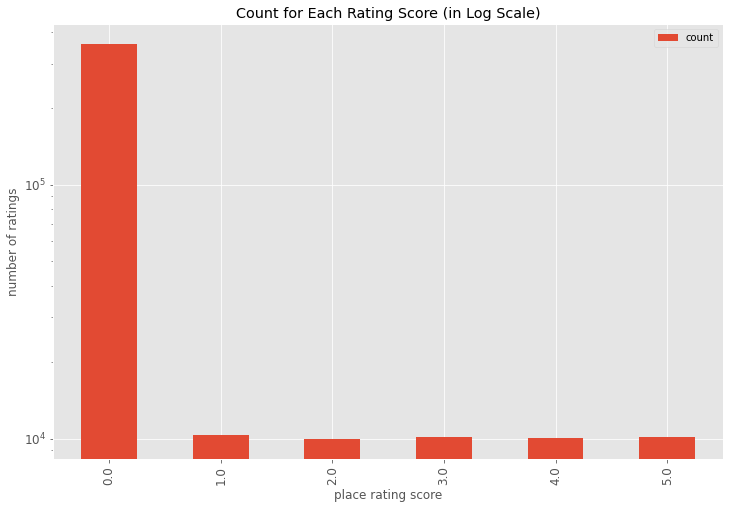

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("place rating score")
ax.set_ylabel("number of ratings")

In [42]:
# get rating frequency
#number of ratings each place got.
df_places_cnt = pd.DataFrame(df_ratings.groupby('placeid').size(), columns=['count'])
df_places_cnt.head()

,count
placeid,
1879183,126
1879221,122
1879224,117
1879227,120
1879237,139


In [43]:
#now we need to take only places that have been rated atleast 50 times to get some idea of the reactions of users towards it
popularity_thres = 50
popular_places = list(set(df_places_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_places = df_ratings[df_ratings.placeid.isin(popular_places)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular places: ', df_ratings_drop_places.shape)

shape of original ratings data:  (50579, 3)
shape of ratings data after dropping unpopular places:  (50579, 3)


In [44]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_places.groupby('userid').size(), columns=['count'])
df_users_cnt.head()

,count
userid,
1,92
2,91
3,39
4,11
5,20


In [45]:
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_places[df_ratings_drop_places.userid.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular places and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (50579, 3)
shape of ratings data after dropping both unpopular places and inactive users:  (48701, 3)


In [46]:
df_ratings_drop_users

,userid,placeid,rating
0,1,5167809,3
1,1,1879958,3
2,1,4982513,2
3,1,4906168,5
4,1,15832604,3
...,...,...,...
50574,2090,4982507,4
50575,2090,7989627,2
50576,2090,4982508,1
50577,2090,7979443,2


In [47]:
# pivot and create place-user matrix
place_user_mat = df_ratings_drop_users.pivot(index='placeid', columns='userid', values='rating').fillna(0)
#map place titles to images
place_to_idx = {
    place: i for i, place in 
    enumerate(list(df_places.set_index('features__id').loc[place_user_mat.index].features__properties__name))
}
# transform matrix to scipy sparse matrix
place_user_mat_sparse = csr_matrix(place_user_mat.values)

In [48]:
place_user_mat_sparse

<410x820 sparse matrix of type '<class 'numpy.float64'>'
	with 48701 stored elements in Compressed Sparse Row format>

# Starting CF Recommendation using KNN

In [49]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(place_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [50]:
from fuzzywuzzy import fuzz

c:\Users\adwai\AppData\Local\Programs\Python\Python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [51]:
def fuzzy_matching(mapper, fav_place, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map place title name to index of the place in data

    fav_place: str, name of user input place
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_place.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [52]:
def make_recommendation(model_knn, data, mapper, fav_place, n_recommendations):
    """
    return top n similar place recommendations based on user's input place


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: place-user matrix

    mapper: dict, map place title name to index of the place in data

    fav_place: str, name of user input place

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar place recommendations
    """
    # fit
    model_knn.fit(data)
    # get input place index
    print('You have input place:', fav_place)
    idx = fuzzy_matching(mapper, fav_place, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_place))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [53]:
my_favorite = 'COEP Auditorium'

make_recommendation(
    model_knn=model_knn,
    data=place_user_mat_sparse,
    fav_place=my_favorite,
    mapper=place_to_idx,
    n_recommendations=10)

You have input place: COEP Auditorium
Found possible matches in our database: ['COEP Auditorium', 'Auditorium', 'Mini Auditorium COEP', 'Susie Sorabjee Auditorium']

Recommendation system start to make inference
......

Recommendations for COEP Auditorium:
1: Krushnarao Gangurde, with distance of 0.7958429594755412
2: Bhajiram Mandir, with distance of 0.7950042735541815
3: Modi Ganpati, with distance of 0.7863732485246839
4: Untade Maruti Mandir, with distance of 0.7845081137824996
5: Shiv Mandir, with distance of 0.7840785151945293
6: Swami Samarth Mandir, with distance of 0.7834701175143169
7: Vithal Rukmini Mandir, with distance of 0.7759129758888746
8: Tuljabhavani Temple, with distance of 0.775182525858815
9: Navagraha Shani Mandir, with distance of 0.7731192256168904
10: Adambag Masjid, with distance of 0.7595002640701629
